plus len 10000 minus len 10000
total len 20000
904
1062
Event plus yield is: 34.78646288825342
Event minus yield is: 19.686202004145983
Total event yield is: 54.4726648923994
Statistical uncertainty is: 2.0054055005886635
Statistical uncertainty for plus data is: 1.8060287192039923
Statistical uncertainty for minus data is: 0.8717290216584819
689 * ?float32
689 * option[var * float64]


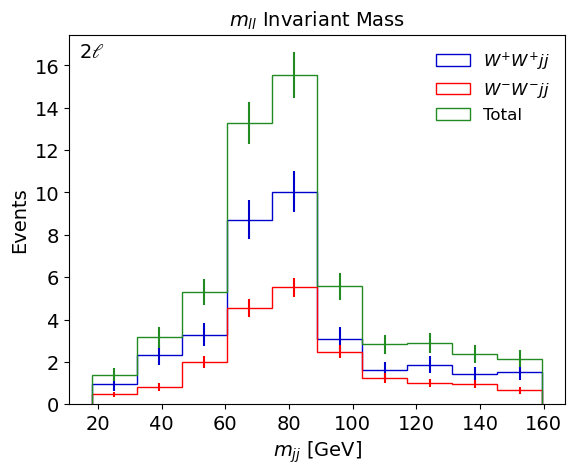

In [ ]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy import stats


m_e = const.electron_mass / 1000
m_mu = 0.105658

def import_data():
    tree_plus = uproot.open('../Delphes/delphes_output_WWJJ_e+mu_modcard_QCD=0.root:Delphes')
    plus_events = tree_plus.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    tree_minus = uproot.open('../Delphes/delphes_output_WWJJ_e-mu_modcard_QCD=0.root:Delphes')
    minus_events = tree_minus.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    print("plus len",len(plus_events['Event.Weight']), "minus len", len(minus_events['Event.Weight']))
    print("total len", len(plus_events['Event.Weight']) + len(minus_events['Event.Weight']))
    
    return plus_events, minus_events

def di_invariant_mass_calc(particles):
    diparticle_mass = (particles[:, 0] + particles[:, 1]).mass  # calculates invariant mass for electron-electron or muon-muon pairs
    return diparticle_mass

def cross_invariant_mass_calc(electrons, muons):
    dilepton_mass = (electrons[:, 0] + muons[:, 0]).mass  # calculates invariant mass for electron-muon pairs
    return dilepton_mass

def delta_eta(particles):
    return np.abs(particles[:, 0].eta - particles[:, 1].eta)

def electron_cuts(events):
    electron_size_mask = events['Electron_size'] == 2
    unfiltered_events = events[electron_size_mask] # Selects dielectrons only

    electron_pt = unfiltered_events['Electron.PT']
    electron_eta = unfiltered_events['Electron.Eta']

    electron_pt_mask = electron_pt > 20
    electron_eta_mask = np.abs(electron_eta) < 2.47
    exclusion_mask = (np.abs(electron_eta) < 1.37) | (np.abs(electron_eta) > 1.52)

    total_mask = electron_pt_mask & electron_eta_mask & exclusion_mask
    filtered_mask = ak.sum(total_mask, axis=1) == 2  # Applies discrete cut to the continous cuts

    filtered_electron_pt=electron_pt[electron_pt_mask]
    filtered_events = unfiltered_events[filtered_mask]

    filtered_electrons = vector.zip({
        'pt': filtered_events['Electron.PT'],
        'eta': filtered_events['Electron.Eta'],
        'phi': filtered_events['Electron.Phi'],
        'mass': m_e
    })

    unfiltered_electrons = vector.zip({
        'pt': unfiltered_events['Electron.PT'],
        'eta': unfiltered_events['Electron.Eta'],
        'phi': unfiltered_events['Electron.Phi'],
        'mass': m_e
    })

    dielectron_mass = di_invariant_mass_calc(unfiltered_electrons)
    filtered_dielectron_mass = di_invariant_mass_calc(filtered_electrons)

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights)
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_events['Event.Weight'])) * unfiltered_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    plot_mass(unfiltered_weights, filtered_weights, dielectron_mass, filtered_dielectron_mass, "Dielectron")

def muon_cuts(events):
    muon_size_mask = events['Muon_size'] == 2
    unfiltered_events = events[muon_size_mask]  # Just dimuons selected

    muon_pt = unfiltered_events['Muon.PT']
    muon_eta = unfiltered_events['Muon.Eta']

    muon_pt_mask = muon_pt > 20
    muon_eta_mask = np.abs(muon_eta) < 2.5

    total_mask = muon_pt_mask & muon_eta_mask
    filtered_mask = ak.sum(total_mask, axis=1) == 2  # Ensure there are exactly 2 muons passing the cuts

    filtered_muon_pt = muon_pt[total_mask]
    filtered_events = unfiltered_events[filtered_mask]

    filtered_muons = vector.zip({
        'pt': filtered_events['Muon.PT'],
        'eta': filtered_events['Muon.Eta'],
        'phi': filtered_events['Muon.Phi'],
        'mass': m_mu
    })

    unfiltered_muons = vector.zip({
        'pt': unfiltered_events['Muon.PT'],
        'eta': unfiltered_events['Muon.Eta'],
        'phi': unfiltered_events['Muon.Phi'],
        'mass': m_mu
    })

    dimuon_mass = di_invariant_mass_calc(unfiltered_muons)
    filtered_dimuon_mass = di_invariant_mass_calc(filtered_muons)

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights)
    
    unfiltered_weights = (weight_normalisation * np.ones_like(unfiltered_events['Event.Weight'])) * unfiltered_events['Event.Weight']
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    plot_mass(unfiltered_weights, filtered_weights, dimuon_mass, filtered_dimuon_mass, "Dimuon")

def electron_muon_cuts(events, cross_section, k_factor):
    cut_flow_counts = {
        'Initial': len(events),
        'Single Lepton Selection': 0,
        'Pt and Eta Lepton Cuts': 0,
        'Highest Pt Lepton': 0,
        'Invariant Mass Lepton Cuts': 0,
        'Jet Size': 0,
        'Pt and Eta Jet Cuts': 0,
        'Delta Eta Jet Cut': 0,
        'Invariant Mass Jet Cut': 0
        }

    single_electron_muon_mask = (events['Electron_size'] == 1) & (events['Muon_size'] == 1)
    unfiltered_events = events[single_electron_muon_mask]
    cut_flow_counts['Single Lepton Selection'] = len(unfiltered_events)

    electron_pt = unfiltered_events['Electron.PT']
    electron_eta = unfiltered_events['Electron.Eta']
    muon_pt = unfiltered_events['Muon.PT']
    muon_eta = unfiltered_events['Muon.Eta']

    electron_pt_mask = electron_pt > 20
    electron_eta_mask = np.abs(electron_eta) < 2.47
    exclusion_mask = (np.abs(electron_eta) < 1.37) | (np.abs(electron_eta) > 1.52)
    total_electron_mask = electron_pt_mask & electron_eta_mask & exclusion_mask
    muon_pt_mask = muon_pt > 20
    muon_eta_mask = np.abs(muon_eta) < 2.5
    total_muon_mask = muon_pt_mask & muon_eta_mask

    filtered_mask = (ak.sum(total_electron_mask, axis=1) == 1) & (ak.sum(total_muon_mask, axis=1) == 1)
 
    cut_flow_counts['Pt and Eta Lepton Cuts'] = len(unfiltered_events[filtered_mask])

    highest_pt_lepton_mask = (electron_pt >= muon_pt)
    highest_pt_cut = 27
    highest_pt_mask = ((highest_pt_lepton_mask & (electron_pt > highest_pt_cut)) | 
                       (~highest_pt_lepton_mask & (muon_pt > highest_pt_cut)))
    
    total_electron_mask = total_electron_mask & highest_pt_mask
    filtered_mask = (ak.sum(total_electron_mask, axis=1) == 1) & (ak.sum(total_muon_mask, axis=1) == 1)
    
    filtered_events = unfiltered_events[filtered_mask]
    cut_flow_counts['Highest Pt Lepton'] = len(filtered_events)

    filtered_electrons = vector.zip({
        'pt': filtered_events['Electron.PT'],
        'eta': filtered_events['Electron.Eta'],
        'phi': filtered_events['Electron.Phi'],
        'mass': m_e
    })
    filtered_muons = vector.zip({
        'pt': filtered_events['Muon.PT'],
        'eta': filtered_events['Muon.Eta'],
        'phi': filtered_events['Muon.Phi'],
        'mass': m_mu
    })
    filtered_electron_muon_mass = cross_invariant_mass_calc(filtered_electrons, filtered_muons)
    electron_muon_invariant_mass_mask = (filtered_electron_muon_mass > 40) & (filtered_electron_muon_mass < 400)
    filtered_electron_muon_mass = filtered_electron_muon_mass[electron_muon_invariant_mass_mask]

    filtered_events = filtered_events[electron_muon_invariant_mass_mask]
    cut_flow_counts['Invariant Mass Lepton Cuts'] = len(filtered_events)

    weights = events['Event.Weight']
    weight_normalisation = normalisation(weights, cross_section, k_factor)
    
    filtered_weights = (weight_normalisation * np.ones_like(filtered_events['Event.Weight'])) * filtered_events['Event.Weight']

    #plot_mass(filtered_weights, filtered_electron_muon_mass, "Electron-Muon")

    return filtered_events, cut_flow_counts

def jet_cuts(filtered_events, events, cross_section, k_factor, cut_flow_counts):
    jet_size_mask = filtered_events['Jet_size'] >= 2
    unfiltered_input_events = filtered_events
    cut_flow_counts['Jet Size'] = len(filtered_events[jet_size_mask])

    jet_b_tag = filtered_events['Jet.BTag'] == 0
    jet_pt = filtered_events['Jet.PT']
    jet_eta = filtered_events['Jet.Eta']

    forward_jet_mask = ((np.abs(filtered_events['Jet.Eta']) > 2.5) & (np.abs(filtered_events['Jet.Eta']) < 4.5) & (filtered_events['Jet.PT'] > 30)) & jet_b_tag
    central_jet_mask = ((np.abs(filtered_events['Jet.Eta']) < 2.5) & (filtered_events['Jet.PT'] > 20)) & jet_b_tag
    central_jet_region_mask = (abs(filtered_events['Jet.Eta']) < 2.5)

    total_forward_central_mask = forward_jet_mask | central_jet_mask
    filtered_central_jet_mask = (ak.sum(central_jet_region_mask, axis=1) >= 2) & ak.all(total_forward_central_mask, axis=1)
    cut_flow_counts['Pt and Eta Jet Cuts'] = len(filtered_events[filtered_central_jet_mask])

    jet_eta = filtered_events['Jet.Eta'][filtered_central_jet_mask]
    jet_pt = filtered_events['Jet.PT'][filtered_central_jet_mask]
    jet_phi = filtered_events['Jet.Phi'][filtered_central_jet_mask]
    jet_mass = filtered_events['Jet.Mass'][filtered_central_jet_mask]

    jet_pt_masked = jet_pt.mask[jet_eta < 2.5]
    jet_eta_masked = jet_eta.mask[jet_eta < 2.5]
    jet_phi_masked = jet_phi.mask[jet_eta < 2.5]
    jet_mass_masked = jet_mass.mask[jet_eta < 2.5]

    jets = vector.zip({
        'pt':filtered_events['Jet.PT'],
        'eta':filtered_events['Jet.Eta'],
        'phi':filtered_events['Jet.Phi'],
        'mass':filtered_events['Jet.Mass']
    })

    jets_central = vector.zip({
        'pt':jet_pt_masked,
        'eta':jet_eta_masked,
        'phi':jet_phi_masked,
        'mass':jet_mass_masked
    })

    filtered_jets = jets[filtered_central_jet_mask]
    central_jet_mass = di_invariant_mass_calc(jets_central)
    central_jet_eta = delta_eta(jets_central)

    jets_central_mass_cut_mask = (central_jet_mass < 160)
    cut_flow_counts['Invariant Mass Jet Cut'] = len(filtered_events[jets_central_mass_cut_mask])
    jets_central_delta_eta_cut_mask = (central_jet_eta < 1.5)
    cut_flow_counts['Delta Eta Jet Cut'] = len(filtered_events[jets_central_delta_eta_cut_mask])
    print(len(filtered_events[jets_central_delta_eta_cut_mask]))

    central_jet_cut_mask = jets_central_mass_cut_mask & jets_central_delta_eta_cut_mask

    final_filtered_jets = filtered_jets[central_jet_cut_mask]

    filtered_jet_mass = di_invariant_mass_calc(final_filtered_jets)

    weights = events['Event.Weight']
    new_weights = filtered_events['Event.Weight']
    weight_normalisation = normalisation(weights, cross_section, k_factor)

    filtered_weights = new_weights[filtered_central_jet_mask]
    filtered_weights = new_weights[central_jet_cut_mask]
    
    filtered_weights = (weight_normalisation * np.ones_like(filtered_weights)) * filtered_weights
    #plot_mass(filtered_weights, filtered_jet_mass, "Dijet")
    cut_flow_counts['Total Cuts'] = len(final_filtered_jets)
    #plot_cut_flow(cut_flow_counts)

    return filtered_weights, filtered_jet_mass

def normalisation(weights, cross_section, k_factor):
    #plus data cross_section = 3.65 fb, minus data cross_section = 1.4368 fb
    #k_factor = (136 / 73.69) first is for w+w+w- and second is for w+w-w- (76 / 39.26)
    luminosity = 139 # fb^-1
    normalised_weight = (1 / np.sum(weights)) * luminosity * cross_section * k_factor

    return normalised_weight 

def plot_mass(filtered_weights, filtered_mass, flavour):
    print("Event yield is:",np.sum(filtered_weights),".")

    plt.hist(filtered_mass, bins=50, range=(np.min(filtered_mass), np.max(filtered_mass)), weights=filtered_weights, label="Filtered Data")

    plt.title(f"Filtered {flavour} Invariant Mass Data")
    plt.xlabel('Mass [GeV]')
    plt.ylabel('Events')
    plt.legend()
    plt.savefig(f"filtered_{flavour.lower()}_invariant_mass.png", dpi=1000)
    plt.show()

def plot_cut_flow(cut_flow_counts):
    labels = list(cut_flow_counts.keys())
    counts = list(cut_flow_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.ylabel('Number of Events')
    plt.title('Cut Flow Diagram')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig("di_lepton_cut_flow_diagram.png", dpi=1000)
    plt.show()

def variance(values):
    return np.sqrt(np.sum(values**2))

def plot_multi_mass(plus_filtered_weights, minus_filtered_weights, plus_filtered_mass, minus_filtered_mass):
    print("Event plus yield is:",(np.sum(plus_filtered_weights)))
    print("Event minus yield is:",(np.sum(minus_filtered_weights)))
    print("Total event yield is:",(np.sum(plus_filtered_weights) + np.sum(minus_filtered_weights)))
    print("Statistical uncertainty is:", np.sqrt(np.sum(plus_filtered_weights ** 2) + np.sum(minus_filtered_weights **2)))
    print("Statistical uncertainty for plus data is:", np.sqrt(np.sum(plus_filtered_weights ** 2)))
    print("Statistical uncertainty for minus data is:", np.sqrt(np.sum(minus_filtered_weights ** 2)))


    print(ak.type(plus_filtered_mass))
    print(ak.type(plus_filtered_weights))
    bin_number = 10
    range1=(20, 160)
    plus_filtered_mass = ak.to_numpy(plus_filtered_mass)
    minus_filtered_mass = ak.to_numpy(minus_filtered_mass)
    plus_filtered_weights = ak.to_numpy(plus_filtered_weights)[:,0]
    minus_filtered_weights = ak.to_numpy(minus_filtered_weights)[:,0]

    bin_edges = np.linspace(
        min(np.min(plus_filtered_mass), np.min(minus_filtered_mass)),
        max(np.max(plus_filtered_mass), np.max(minus_filtered_mass)),
        bin_number + 1)

    height_0 = plt.hist(plus_filtered_mass, bins=bin_edges, weights=plus_filtered_weights, label="$W^{+}W^{+}jj$", color='mediumblue', histtype='step')
    height_1 = plt.hist(minus_filtered_mass, bins=bin_edges, weights=minus_filtered_weights, label="$W^{-}W^{-}jj$", color='red', histtype='step')
    total_heights = height_0[0] + height_1[0]
    
    plt.hist(bin_edges[:-1], bins=bin_edges, weights=total_heights, label="Total", color='forestgreen', histtype='step')

    error_0 = stats.binned_statistic(plus_filtered_mass, plus_filtered_weights, statistic=variance, bins=bin_edges)[0]
    error_1 = stats.binned_statistic(minus_filtered_mass, minus_filtered_weights, statistic=variance, bins=bin_edges)[0]
    error_2 = np.sqrt(error_0**2 + error_1**2)

    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    plt.errorbar(bin_centres, height_0[0], yerr=error_0, fmt='none', color='mediumblue')
    plt.errorbar(bin_centres, height_1[0], yerr=error_1, fmt='none', color='red')
    plt.errorbar(bin_centres, total_heights, yerr=error_2, fmt='none', color='forestgreen')

    plt.text(0.02, 0.98, "$2\mathscr{l}$", transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.title('$m_{jj}$ Invariant Mass', fontsize=14)
    plt.xlabel('$m_{jj}$ [GeV]', fontsize=14)
    plt.ylabel('Events', fontsize=14)
    plt.legend(frameon=False, fontsize=12)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    plt.savefig("plus_minus_stacked_filtered_electron_muon_invariant_mass_QCD=0.png", dpi=1000)
    plt.show()

def print_branches(tree):
    keys = tree.keys()
    for key in keys:
        print(key)
    
def __main__():
    plus_events, minus_events = import_data()
    #electron_cuts(events)
    #muon_cuts(events)
    plus_cross_section = 3.651
    minus_cross_section = 1.437
    plus_k_factor = 136 / 73.69
    minus_k_factor = 76 / 39.26

    plus_filtered_events, plus_cut_flow_counts = electron_muon_cuts(plus_events, plus_cross_section, plus_k_factor)
    minus_filtered_events, minus_cut_flow_counts = electron_muon_cuts(minus_events, minus_cross_section, minus_k_factor)
    
    plus_filtered_weights, plus_filtered_jet_mass = jet_cuts(plus_filtered_events, plus_events, plus_cross_section, plus_k_factor, plus_cut_flow_counts)
    minus_filtered_weights, minus_filtered_jet_mass = jet_cuts(minus_filtered_events, minus_events, minus_cross_section, minus_k_factor, minus_cut_flow_counts)
    
    plot_multi_mass(plus_filtered_weights, minus_filtered_weights, plus_filtered_jet_mass, minus_filtered_jet_mass)
    #print_branches(tree)

if __name__ == '__main__':
    __main__()

plus len 2000 minus len 2000
total len 4000
[154, 239, 205, 234, 190, 450, 110, ..., 353, 150, 137, 345, 222, 189, 75.5]
Event plus yield is: 10.819606109126141
Event minus yield is: 3.7342015326373956
Total event yield is: 14.553807641763537
Total Statistical uncertainty is: 1.2316567767962796
Statistical uncertainty for plus data is: 1.1219408891174005
Statistical uncertainty for minus data is: 0.5081604639822515
93 * float64
93 * var * float64


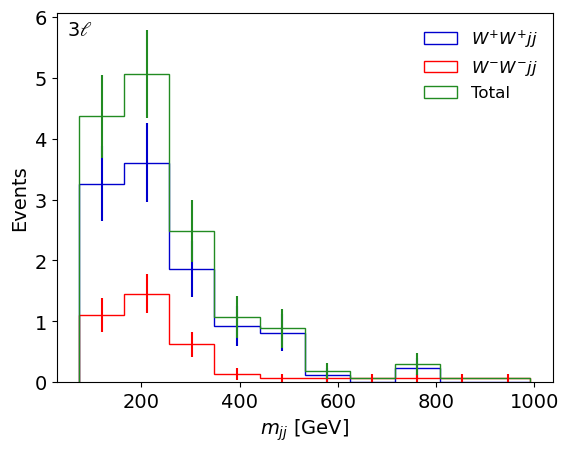

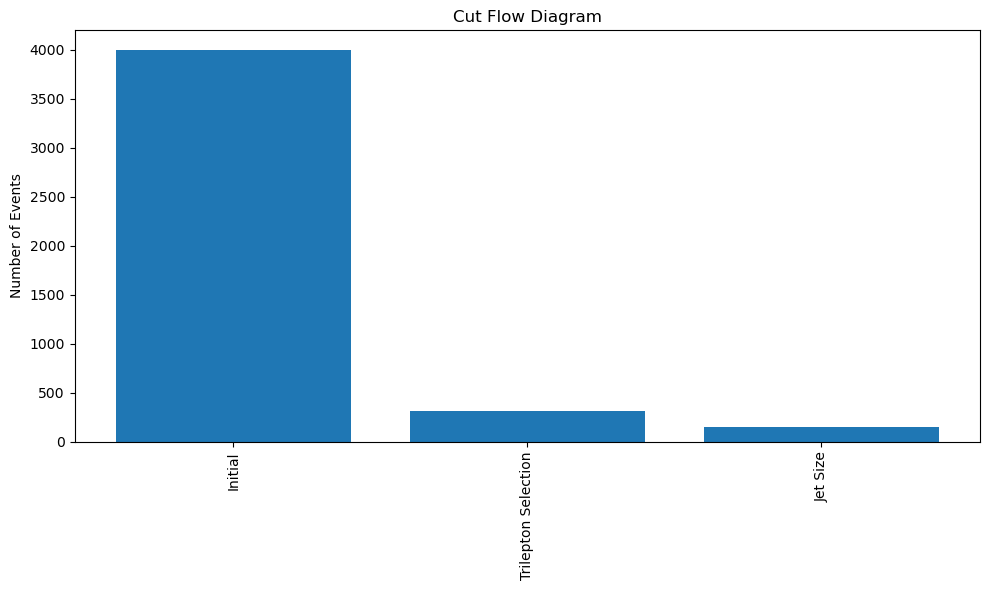

In [3]:
import uproot
import awkward as ak
import vector
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
from scipy import stats

m_e = const.electron_mass / 1000
m_mu = 0.105658

def import_data():
    tree_plus = uproot.open('../Delphes/delphes_output_l+l+l-.root:Delphes')
    plus_events = tree_plus.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    
    tree_minus = uproot.open('../Delphes/delphes_output_l+l-l-.root:Delphes')
    minus_events = tree_minus.arrays(['Event.Weight', 'Electron_size', 'Electron.Eta', 'Electron.PT',
                           'Electron.Phi', 'Muon_size', 'Muon.PT', 'Muon.Eta', 'Muon.Phi',
                           'Jet_size', 'Jet.PT', 'Jet.Eta', 'Jet.Phi','Jet.Mass','Jet.BTag',])
    print("plus len",len(plus_events['Event.Weight']), "minus len", len(minus_events['Event.Weight']))
    print("total len", len(plus_events['Event.Weight']) + len(minus_events['Event.Weight']))
    return plus_events, minus_events

def trilepton_invariant_mass_calc(electrons, muons):
    all_leptons = ak.concatenate([electrons, muons], axis=1)
    valid_leptons = all_leptons[ak.num(all_leptons) == 3]

    trilepton_masses = (valid_leptons[:, 0] + valid_leptons[:, 1] + valid_leptons[:, 2]).mass

    return trilepton_masses

def trilepton_cuts(plus_events, minus_events, plus_cross_section, minus_cross_section, plus_k_factor, minus_k_factor):
    cut_flow_counts = {
        'Initial': len(plus_events)+ len(minus_events),
        'Trilepton Selection': 0,
        'Jet Size': 0}

    plus_electron_pt = plus_events['Electron.PT']
    minus_electron_pt = minus_events['Electron.PT']
    plus_electron_eta = plus_events['Electron.Eta']
    minus_electron_eta = minus_events['Electron.Eta']
    plus_muon_pt = plus_events['Muon.PT']
    minus_muon_pt = minus_events['Muon.PT']
    plus_muon_eta = plus_events['Muon.Eta']
    minus_muon_eta = minus_events['Muon.Eta']

    plus_electron_pt_mask = plus_electron_pt > 20
    minus_electron_pt_mask = minus_electron_pt > 20
    plus_electron_eta_mask = np.abs(plus_electron_eta) < 2.47
    minus_electron_eta_mask = np.abs(minus_electron_eta) < 2.47
    plus_exclusion_mask = (np.abs(plus_electron_eta) < 1.37) | (np.abs(plus_electron_eta) > 1.52)
    minus_exclusion_mask = (np.abs(minus_electron_eta) < 1.37) | (np.abs(minus_electron_eta) > 1.52)
    plus_total_electron_mask = plus_electron_pt_mask & plus_electron_eta_mask & plus_exclusion_mask
    minus_total_electron_mask = minus_electron_pt_mask & minus_electron_eta_mask & minus_exclusion_mask 

    plus_muon_pt_mask = plus_muon_pt > 20
    minus_muon_pt_mask = minus_muon_pt > 20
    plus_muon_eta_mask = np.abs(plus_muon_eta) < 2.5
    minus_muon_eta_mask = np.abs(minus_muon_eta) < 2.5
    plus_total_muon_mask = plus_muon_pt_mask & plus_muon_eta_mask
    minus_total_muon_mask = minus_muon_pt_mask & minus_muon_eta_mask

    plus_filtered_mask = ((ak.sum(plus_total_electron_mask, axis=1) + ak.sum(plus_total_muon_mask, axis=1)) == 3) & (
        ((ak.sum(plus_total_muon_mask, axis=1) == 2) & (ak.sum(minus_total_electron_mask, axis=1) == 1)) |
        ((ak.sum(plus_total_electron_mask, axis=1) == 2) & (ak.sum(minus_total_muon_mask, axis=1) == 1)))

    minus_filtered_mask = ((ak.sum(minus_total_electron_mask, axis=1) + ak.sum(minus_total_muon_mask, axis=1)) == 3) & (
        ((ak.sum(minus_total_muon_mask, axis=1) == 2) & (ak.sum(plus_total_electron_mask, axis=1) == 1)) |
        ((ak.sum(minus_total_electron_mask, axis=1) == 2) & (ak.sum(plus_total_muon_mask, axis=1) == 1)))

    plus_high_pt_lepton_mask = (ak.any(plus_electron_pt > 27, axis=1) | ak.any(plus_muon_pt > 27, axis=1))
    minus_high_pt_lepton_mask = (ak.any(minus_electron_pt > 27, axis=1) | ak.any(minus_muon_pt > 27, axis=1))

    plus_final_mask = plus_filtered_mask & plus_high_pt_lepton_mask
    minus_final_mask = minus_filtered_mask & minus_high_pt_lepton_mask
    filtered_plus_events = plus_events[plus_final_mask]
    filtered_minus_events = minus_events[minus_final_mask]

    cut_flow_counts['Trilepton Selection'] = len(filtered_plus_events) + len(filtered_minus_events)
    
    plus_b_jet_mask = filtered_plus_events['Jet.BTag'] == 0
    minus_b_jet_mask = filtered_minus_events['Jet.BTag'] == 0
    plus_b_jet_event_mask = ak.any(plus_b_jet_mask, axis=1)
    minus_b_jet_event_mask = ak.any(minus_b_jet_mask, axis=1)

    filtered_plus_events = filtered_plus_events[plus_b_jet_event_mask]
    filtered_minus_events = filtered_minus_events[minus_b_jet_event_mask]

    cut_flow_counts['Jet Size'] = len(filtered_plus_events) + len(filtered_minus_events)

    filtered_plus_electron_events = vector.zip({
        'pt': filtered_plus_events['Electron.PT'],
        'eta': filtered_plus_events['Electron.Eta'],
        'phi': filtered_plus_events['Electron.Phi'],
        'mass': m_e
    })
    filtered_minus_electron_events = vector.zip({
        'pt': filtered_minus_events['Electron.PT'],
        'eta': filtered_minus_events['Electron.Eta'],
        'phi': filtered_minus_events['Electron.Phi'],
        'mass': m_e
    })
    filtered_plus_muon_events = vector.zip({
        'pt': filtered_plus_events['Muon.PT'],
        'eta': filtered_plus_events['Muon.Eta'],
        'phi': filtered_plus_events['Muon.Phi'],
        'mass': m_mu
    })
    filtered_minus_muon_events = vector.zip({
        'pt': filtered_minus_events['Muon.PT'],
        'eta': filtered_minus_events['Muon.Eta'],
        'phi': filtered_minus_events['Muon.Phi'],
        'mass': m_mu
    })

    plus_invariant_mass = trilepton_invariant_mass_calc(filtered_plus_electron_events, filtered_plus_muon_events)
    minus_invariant_mass = trilepton_invariant_mass_calc(filtered_minus_electron_events, filtered_minus_muon_events)
    print(plus_invariant_mass)

    plus_weights = plus_events['Event.Weight']
    plus_weight_normalisation = normalisation(plus_weights, plus_cross_section, plus_k_factor)
    
    minus_weights = minus_events['Event.Weight']
    minus_weight_normalisation = normalisation(minus_weights, minus_cross_section, minus_k_factor)

    plus_filtered_weights = (plus_weight_normalisation * np.ones_like(filtered_plus_events['Event.Weight'])) * filtered_plus_events['Event.Weight']
    minus_filtered_weights = (minus_weight_normalisation * np.ones_like(filtered_minus_events['Event.Weight'])) * filtered_minus_events['Event.Weight']

    return plus_filtered_weights, minus_filtered_weights, plus_invariant_mass, minus_invariant_mass, cut_flow_counts

def normalisation(weights, cross_section, k_factor):
    #plus data cross_section = 0.907 fb, minus data cross_section = 0.514 fb
    #k_factor = (136 / 73.69) first is for w+w+w- and second is for w+w-w- (76 / 39.26)
    luminosity = 139 # fb^-1
    normalised_weight = (1 / np.sum(weights)) * luminosity * cross_section * k_factor
    
    return normalised_weight 

def plot_cut_flow(cut_flow_counts):
    labels = list(cut_flow_counts.keys())
    counts = list(cut_flow_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts)
    plt.ylabel('Number of Events')
    plt.title('Cut Flow Diagram')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig("tri_lepton_cut_flow_diagram.png", dpi=1000)
    plt.show()

def variance(values):
    return np.sqrt(np.sum(values**2))

def plot_multi_mass(plus_filtered_weights, minus_filtered_weights, plus_filtered_mass, minus_filtered_mass):
    print("Event plus yield is:",(np.sum(plus_filtered_weights)))
    print("Event minus yield is:",(np.sum(minus_filtered_weights)))
    print("Total event yield is:",(np.sum(plus_filtered_weights) + np.sum(minus_filtered_weights)))
    print("Total Statistical uncertainty is:", np.sqrt(np.sum(plus_filtered_weights ** 2) + np.sum(minus_filtered_weights **2)))
    print("Statistical uncertainty for plus data is:", np.sqrt(np.sum(plus_filtered_weights ** 2)))
    print("Statistical uncertainty for minus data is:", np.sqrt(np.sum(minus_filtered_weights ** 2)))

    print(ak.type(plus_filtered_mass))
    print(ak.type(plus_filtered_weights))
    bin_number = 10
    range1=(20, 160)
    plus_filtered_mass = ak.to_numpy(plus_filtered_mass)
    minus_filtered_mass = ak.to_numpy(minus_filtered_mass)
    plus_filtered_weights = ak.to_numpy(plus_filtered_weights)[:,0]
    minus_filtered_weights = ak.to_numpy(minus_filtered_weights)[:,0]

    bin_edges = np.linspace(
        min(np.min(plus_filtered_mass), np.min(minus_filtered_mass)),
        max(np.max(plus_filtered_mass), np.max(minus_filtered_mass)),
        bin_number + 1)

    height_0 = plt.hist(plus_filtered_mass, bins=bin_edges, weights=plus_filtered_weights, label="$W^{+}W^{+}jj$", color='mediumblue', histtype='step')
    height_1 = plt.hist(minus_filtered_mass, bins=bin_edges, weights=minus_filtered_weights, label="$W^{-}W^{-}jj$", color='red', histtype='step')
    total_heights = height_0[0] + height_1[0]
    
    plt.hist(bin_edges[:-1], bins=bin_edges, weights=total_heights, label="Total", color='forestgreen', histtype='step')

    error_0 = stats.binned_statistic(plus_filtered_mass, plus_filtered_weights, statistic=variance, bins=bin_edges)[0]
    error_1 = stats.binned_statistic(minus_filtered_mass, minus_filtered_weights, statistic=variance, bins=bin_edges)[0]
    error_2 = np.sqrt(error_0**2 + error_1**2)

    bin_centres = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    plt.errorbar(bin_centres, height_0[0], yerr=error_0, fmt='none', color='mediumblue')
    plt.errorbar(bin_centres, height_1[0], yerr=error_1, fmt='none', color='red')
    plt.errorbar(bin_centres, total_heights, yerr=error_2, fmt='none', color='forestgreen')

    plt.text(0.02, 0.98, "$3\mathscr{l}$", transform=plt.gca().transAxes, fontsize=14, verticalalignment='top')
    plt.title('$m_{jj}$ Invariant Mass', fontsize=14)
    plt.xlabel('$m_{jj}$ [GeV]', fontsize=14)
    plt.ylabel('Events', fontsize=14)
    plt.xticks(fontsize=14)  
    plt.yticks(fontsize=14)
    plt.legend(frameon=False, fontsize=12)
    plt.savefig("plus_minus_trilepton_invariant_mass.png", dpi=1000)
    plt.show()

def __main__():
    plus_events, minus_events = import_data()
    plus_cross_section = 0.907
    minus_cross_section = 0.514
    plus_k_factor = 136 / 73.69
    minus_k_factor = 76 / 39.26
    plus_filtered_weights, minus_filtered_weights, plus_invariant_mass, minus_invariant_mass, cut_flow_counts = trilepton_cuts(plus_events, minus_events, plus_cross_section, minus_cross_section, plus_k_factor, minus_k_factor)
    
    plot_multi_mass(plus_filtered_weights, minus_filtered_weights, plus_invariant_mass, minus_invariant_mass)
    plot_cut_flow(cut_flow_counts)

if __name__ == '__main__':
    __main__()
